# tysserand tutorial

*tysserand* allows you to reconstruct networks from a Mx2 array containing the coordinates of  M points, or from an image resulting from a segmentation step. Segmentation is the detection of areas of interest  like cells or nuclei in microscopy images (details below).  
Here we will see how to reconstruct a network in 4 different ways, but remember: tysserand welcomes very much contributions for new reconstructions methods, automatic parameters setting or improved computational performance!

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import os
from pathlib import Path
import time
import copy
from tysserand import tysserand as ty

In [2]:
# Convenient IPython console
# comment it if you execute Jupyterlab on a remote server

%qtconsole --style monokai

## Make a fake segmentation image

We will generate data mimicking what we can obtain after cell segmentation in an epithelium. For examples, check-out:
  - https://dev.biologists.org/content/144/9/1725
  - https://www.biorxiv.org/content/10.1101/2020.01.17.910562v1.full

In [3]:
# for reproducibility
np.random.seed(0)

In [4]:
coords, masks, image = ty.make_random_tiles(nb=10, return_image=True, noise_sigma=10)

`coords` is a 100x2 array containing the coordinates of "seeds" used to produce the "segmentation areas"

In [5]:
print(coords[:5,:])

[[ 18  19]
 [114   0]
 [231   0]
 [354  10]
 [462   0]]


`image` is really the image used to produce the areas, it contains only the "seeds" for the watershed algorithm

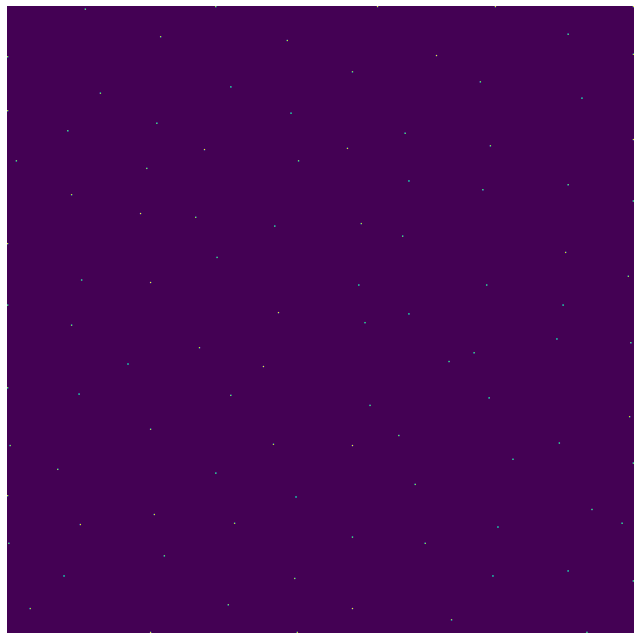

In [6]:
ty.showim(image, origin='lower');

`masks` is the segmentation image.  
It contains areas made of a single integer that refers to its segmentation object ID. Integers range from 0 to K for K detect areas, 0 encodes the background.

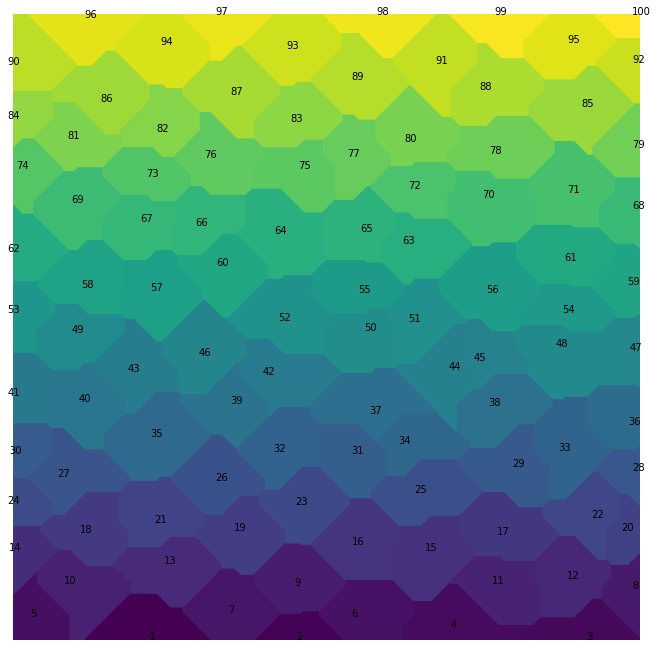

In [7]:
fig, ax = ty.showim(masks, origin='lower')
for (x,y) in coords:
    text = str(masks[y,x])
    plt.text(x-5, y, text, fontdict=None)

To see these areas with more contrast we can use a `scikit-image` function, but sometimes adjacent areas have exactly the same color due to cycling encoding of integer in the colormap.  
Is you know a utility to color-code areas taking advantage of the [4 colors theorem](https://en.wikipedia.org/wiki/Four_color_theorem) I'll be pleased to hear it! :-)

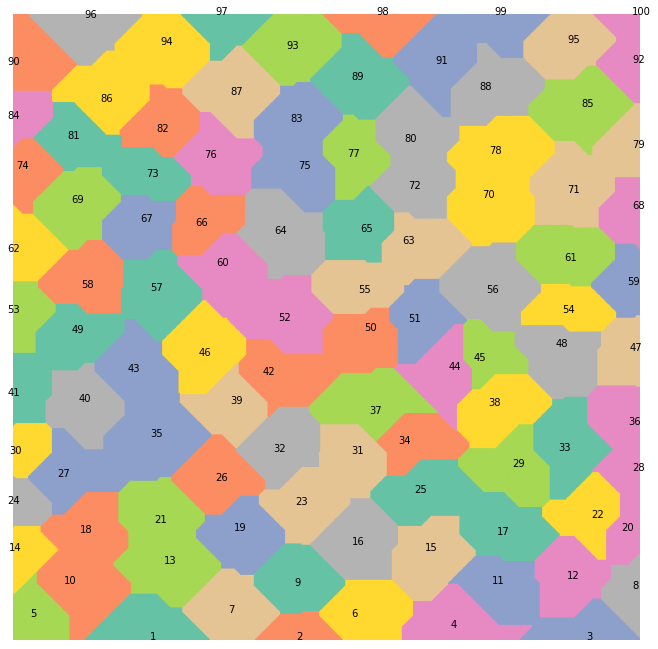

In [8]:
label_cmap = mpl.colormaps.get_cmap('Set2')(range(8))
from skimage import color

fig, ax = ty.showim(color.label2rgb(masks, bg_label=0, colors=label_cmap), origin='lower')
for (x,y) in coords:
    text = str(masks[y,x])
    plt.text(x-5, y, text, fontdict=None)

Let's add some holes

In [9]:
for i in np.unique(masks):
    if np.random.rand() > 0.95:
        masks[masks == i] = 0

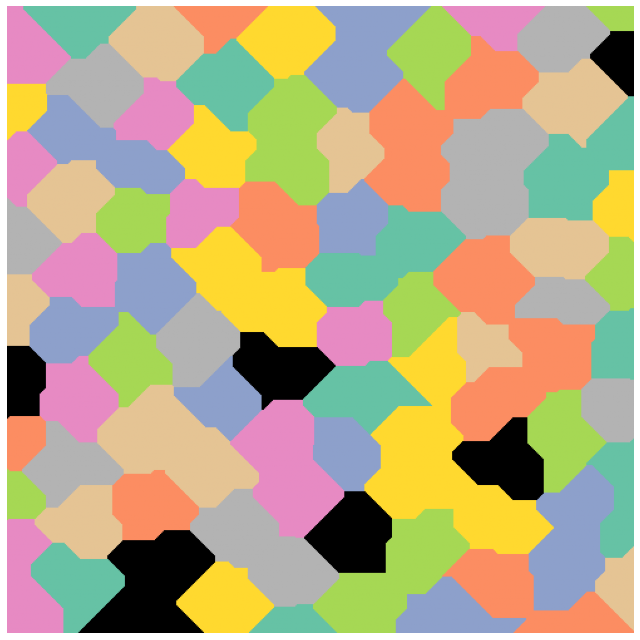

In [10]:
label_cmap = mpl.colormaps.get_cmap('Set2')(range(8))
from skimage import color

fig, ax = ty.showim(color.label2rgb(masks, bg_label=0, colors=label_cmap), origin='lower')

## Network reconstruction

### Area contact

Here we define edges between nodes which areas are in direct contat, or closer than a user-defined distance.  
That is the most relevant method for actual segmentation images.

In [11]:
pairs = ty.build_contacting(masks)
# reencode the coordinates to match node positions with their respective areas
coords = ty.mask_val_coord(masks)
coords, pairs = ty.refactor_coords_pairs(coords, pairs)
distances = ty.distance_neighbors(coords, pairs)

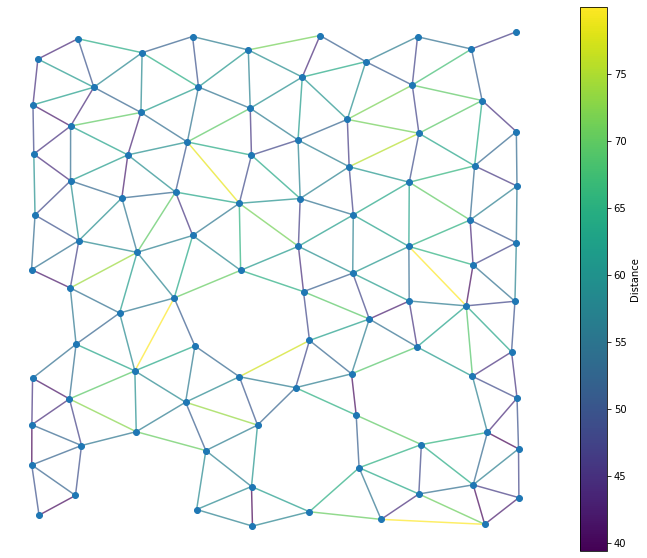

In [12]:
ty.plot_network_distances(coords, pairs, distances, figsize=(13,10))
plt.axis('off');

In [13]:
linewidth = 3

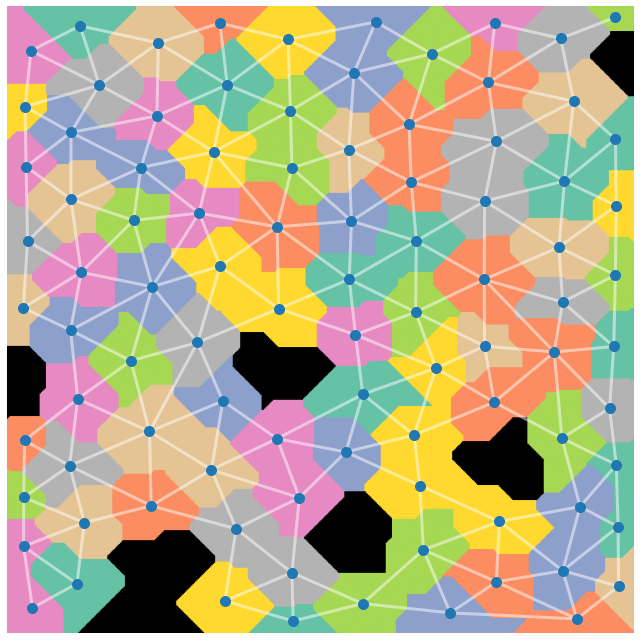

In [14]:
fig, ax = ty.showim(color.label2rgb(masks, bg_label=0, colors=label_cmap), origin='lower')
ty.plot_network(coords, pairs, col_edges='w', size_nodes=100, ax=ax, linewidth=linewidth)

### Delaunay triangulation

In case you *only* have areas positions, but not their boundaries (like if you stain the nuclei but not the membranes), [Delaunay triangulation](https://en.wikipedia.org/wiki/Delaunay_triangulation) produces networks that qualitatively mimick well *epithelium-like* networks. More precisely, edges are in the vast majority defined between actually contacting areas.

In [15]:
pairs = ty.build_delaunay(coords, trim_dist=False)
distances = ty.distance_neighbors(coords, pairs)

The `plot_network_distances` function helps you to define a distance threshold above which edges will be trimmed.

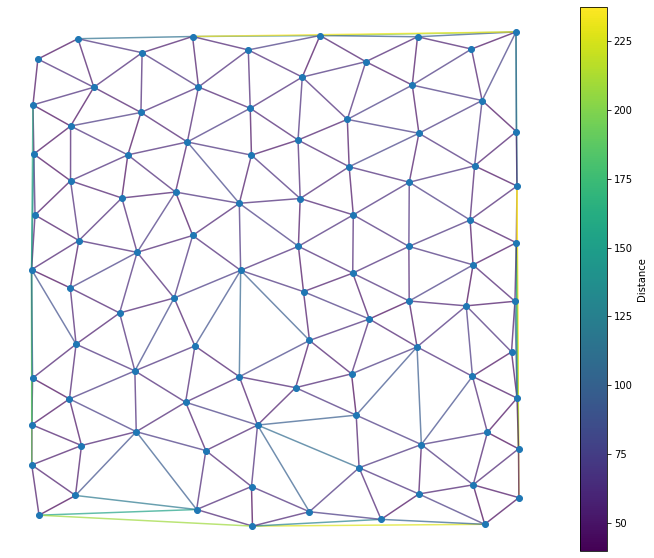

In [16]:
ty.plot_network_distances(coords, pairs, distances, figsize=(13,10))
plt.axis('off');

In [17]:
dist_threshold = 110
select = distances < dist_threshold
pairs = pairs[select,:]

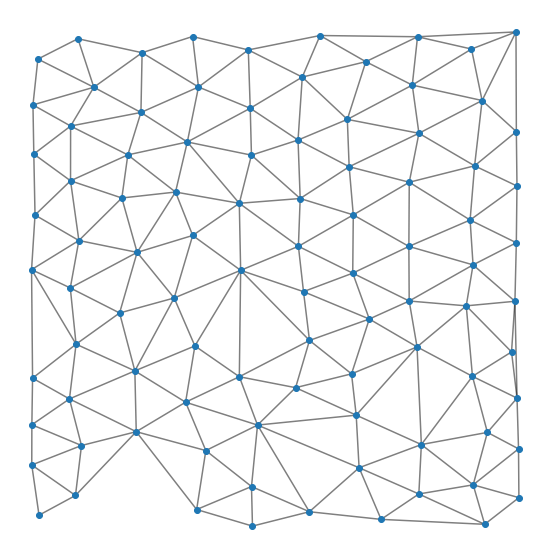

In [18]:
ty.plot_network(coords, pairs, figsize=(10,10))
plt.axis('off');

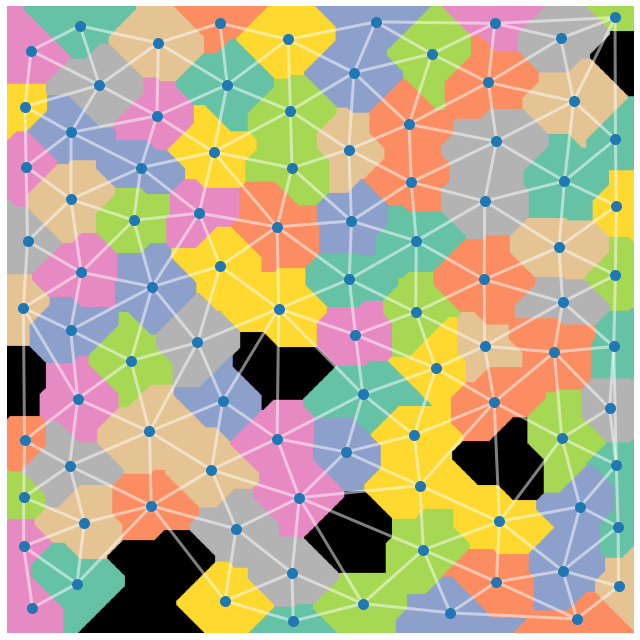

In [19]:
fig, ax = ty.showim(color.label2rgb(masks, bg_label=0, colors=label_cmap), origin='lower')
ty.plot_network(coords, pairs, col_edges='w', size_nodes=100, ax=ax, linewidth=linewidth)

### k-nearest neighbors

k-nearest neighbors (knn) is probably the most common network reconstruction method. In this method, nodes are linked with their knn, you have to choose k.

In [20]:
pairs = ty.build_knn(coords, k=6)
distances = ty.distance_neighbors(coords, pairs)

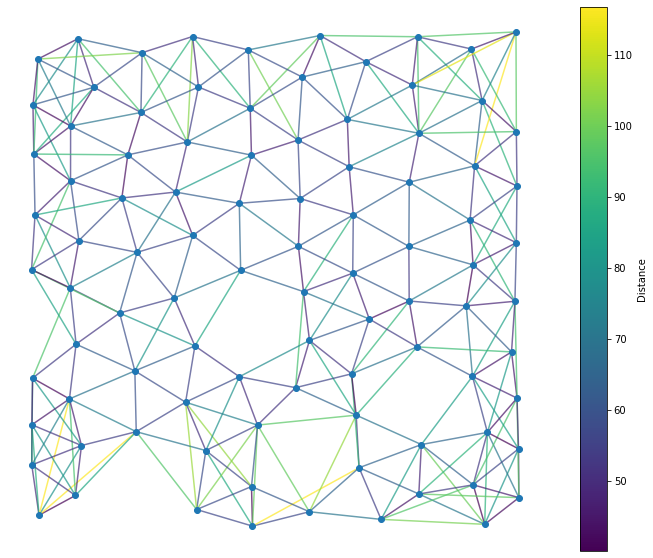

In [21]:
ty.plot_network_distances(coords, pairs, distances, figsize=(13,10))
plt.axis('off');

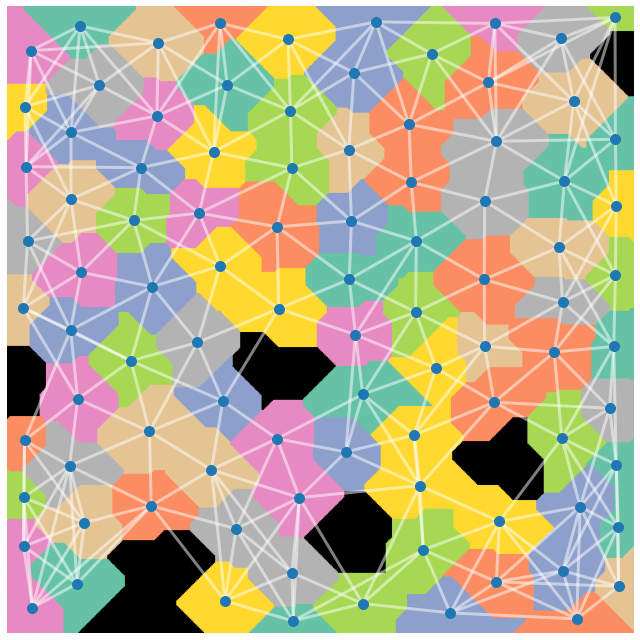

In [22]:
fig, ax = ty.showim(color.label2rgb(masks, bg_label=0, colors=label_cmap), origin='lower')
ty.plot_network(coords, pairs, col_edges='w', size_nodes=100, ax=ax, linewidth=linewidth)
plt.axis('off');

### radial distance neighbors

The radial distance neighbors  method defines edges between each node and nodes that are closer than a given distance threshold. It is well suited to model interactions by diffusing chemicals for instance.

In [23]:
pairs = ty.build_rdn(coords, r=80)
distances = ty.distance_neighbors(coords, pairs)

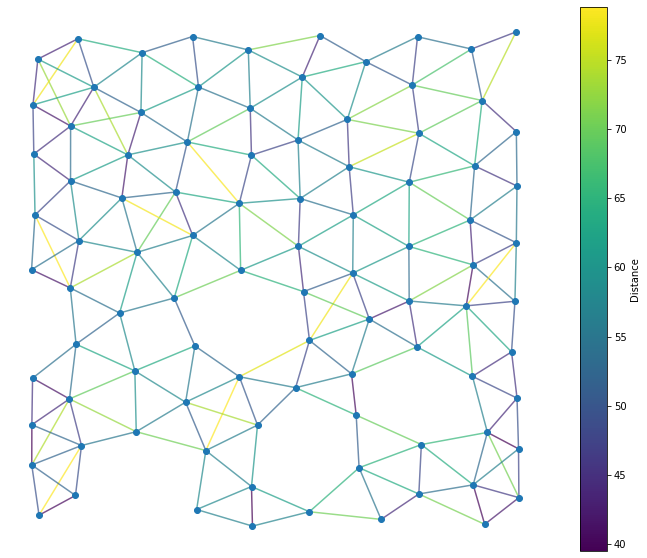

In [24]:
ty.plot_network_distances(coords, pairs, distances, figsize=(13,10))
plt.axis('off');

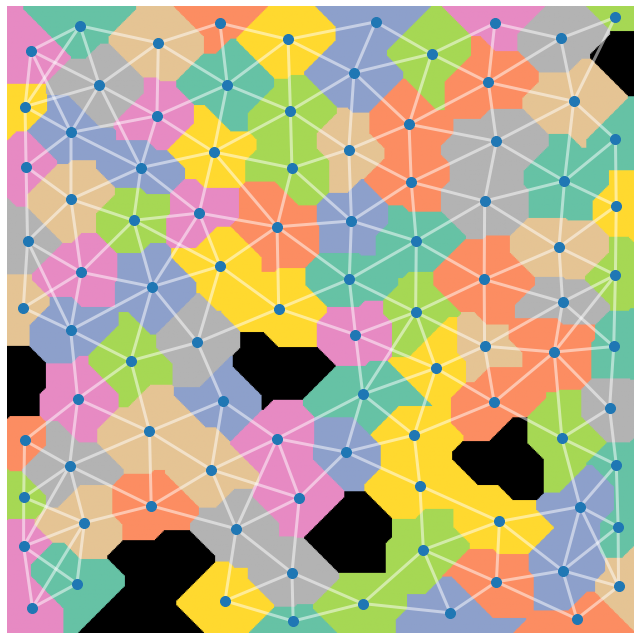

In [25]:
fig, ax = ty.showim(color.label2rgb(masks, bg_label=0, colors=label_cmap), origin='lower')
ty.plot_network(coords, pairs, col_edges='w', size_nodes=100, ax=ax, linewidth=linewidth)
plt.axis('off');

## Export to other libraries

Following the [Unix philosophy](https://en.wikipedia.org/wiki/Unix_philosophy), *tysserand* is meant to do one thing and do it well: reconstruct (spatial) networks.  
Thus, it can communicates the reconstructed networks to other libraries dedicated to network analysis, such as [NetworkX](https://networkx.org/) or [iGraph](https://igraph.org/), or to more specialized libraries like [Scanpy](https://scanpy.readthedocs.io/en/stable/) that can use network representations to analyze single-cell data.  
To run the following examples you need to install these libraries.  
To do so run `pip install networkx igraph cairocffi scanpy`.

Here we use the network reconstructed with the *contacting areas* method.

In [26]:
pairs = ty.build_contacting(masks)
# reencode the coordinates to match node positions with their respective areas
coords = ty.mask_val_coord(masks)
coords, pairs = ty.refactor_coords_pairs(coords, pairs)
distances = ty.distance_neighbors(coords, pairs)

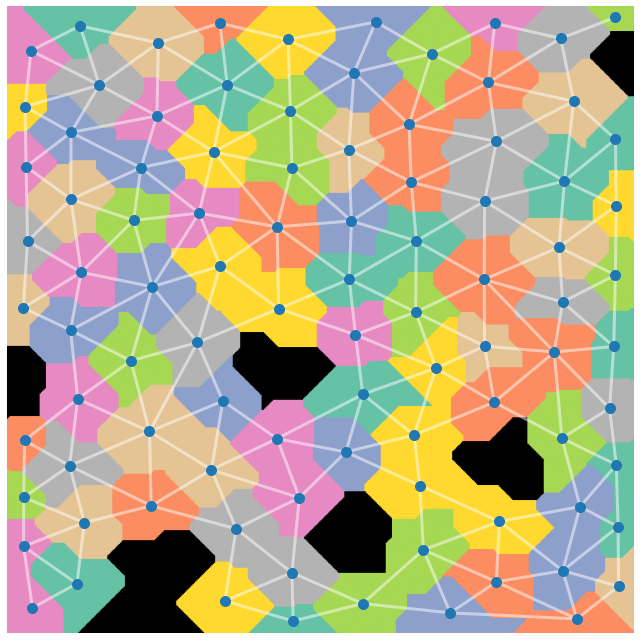

In [27]:
fig, ax = ty.showim(color.label2rgb(masks, bg_label=0, colors=label_cmap), origin='lower')
ty.plot_network(coords, pairs, col_edges='w', size_nodes=100, ax=ax, linewidth=linewidth)

### Make random attributes

Nodes can have multiple attributes (size, color, cell type, cluster class, ...)  
We generate random attributes to illustrate network conversion with attributes.  
We define a dictionary of attribute, where keys are attribute names ('cell types', (fluorescent) 'markers').  
These attributes have multiple modalities (*possible* values).  
Here we generate *non overlaping* attributes, meaning that nodes can have only onemodality for each attribute, which makes sense for cell type but not for *presence* of markers for instance, since a cell can have multiple markers (sorry for the non biologists!)

In [28]:
# enable multimodalities per node:
MULTI_MOD = False

attributes = {'cell_type':['stromal', 'cancer', 'immune'],
              'markers':['PanCK', 'CD8', 'CD4', 'PDL-1', 'CTLA-4']}

nodes_att = pd.DataFrame(data=None, index=np.arange(coords.shape[0]))

if MULTI_MOD:
    for att_name, att_mod in attributes.items():
        att_val = np.random.randint(0, 2, size=(coords.shape[0],len(att_mod))).astype(bool)
        nodes_att = nodes_att.join(pd.DataFrame(att_val, columns=att_mod))
else:
    for att_name, att_mod in attributes.items():
        att_val = np.random.choice(att_mod, coords.shape[0])
        nodes_att = nodes_att.join(pd.DataFrame(att_val, columns=[att_name]))
nodes_att

cell_type markers
0     cancer   PDL-1
1    stromal     CD8
2     cancer   PDL-1
3     immune   PDL-1
4    stromal     CD4
..       ...     ...
88    cancer     CD8
89   stromal  CTLA-4
90    immune  CTLA-4
91    cancer     CD4
92    cancer  CTLA-4

[93 rows x 2 columns]

### To NetworkX

In [29]:
G = ty.to_NetworkX(coords, pairs, attributes=nodes_att)

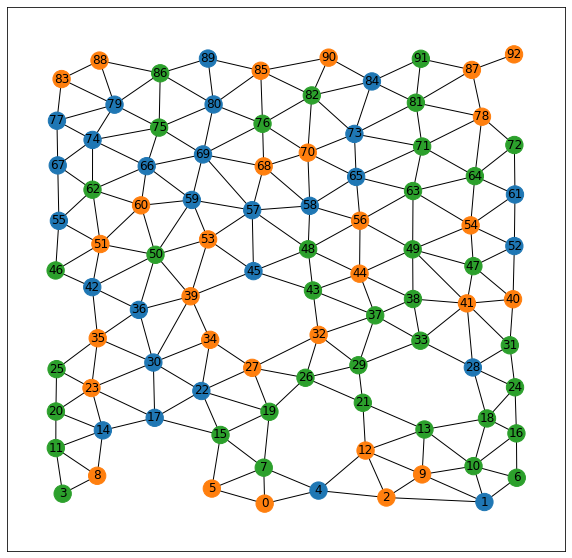

In [30]:
import networkx as nx
pos = {}
for i, (x, y) in enumerate(coords):
    pos[i] = [x, y]
color_mapper = {'stromal':'#1f77b4',
                'cancer':'#ff7f0e',
                'immune':'#2ca02c'}
nodes_color = [color_mapper[x] for x in nodes_att['cell_type']]
fig, ax = plt.subplots(figsize=(10,10))
nx.draw_networkx(G, pos=pos, node_color=nodes_color, ax=ax)

### To iGraph

In [31]:
G = ty.to_iGraph(coords, pairs, attributes=nodes_att)

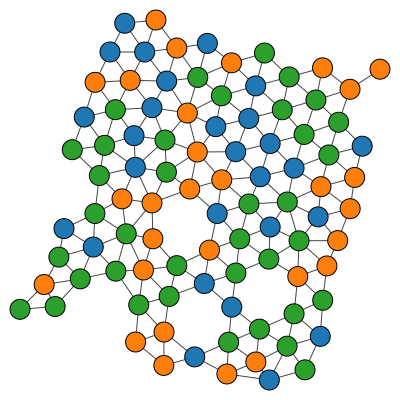

In [32]:
import igraph as ig
layout = G.layout("kk")
color_mapper = {'stromal':'#1f77b4',
                'cancer':'#ff7f0e',
                'immune':'#2ca02c'}
G.vs["color"] = [color_mapper[x] for x in nodes_att['cell_type']]
ig.plot(G, layout=layout, bbox=(400, 400), margin = 20)

### To Scanpy

This assumes you already have  an AnnData object with M cells.  
We will add the spatial network information to this object.  
Here we will use a tutorial of Scanpy to get an AnnData object:  [Preprocessing and clustering 3k PBMCs](https://github.com/theislab/scanpy-tutorials/blob/master/pbmc3k.ipynb), so all the parts concerning data fetching and single-cell processing is from this tutorial.

The data consist in *3k PBMCs from a Healthy Donor* and are freely available from 10x Genomics ([here](http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz) from this [webpage](https://support.10xgenomics.com/single-cell-gene-expression/datasets/1.1.0/pbmc3k)). On a unix system, you can uncomment and run the following to download and unpack the data. The last line creates a directory for writing processed data.

In [33]:
# !mkdir data
# !wget http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz -O data/pbmc3k_filtered_gene_bc_matrices.tar.gz
# !cd data; tar -xzf pbmc3k_filtered_gene_bc_matrices.tar.gz
# !mkdir write

In [34]:
import scanpy as sc

In [35]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

results_file = '../../test/write/pbmc3k.h5ad'  # the file that will store the analysis results

# Read in the count matrix into an [`AnnData`](https://anndata.readthedocs.io/en/latest/anndata.AnnData.html) object, which holds many slots for annotations and different representations of the data. It also comes with its own HDF5 file format: `.h5ad`.
adata = sc.read_10x_mtx(
    '../../test/data/filtered_gene_bc_matrices/hg19/',  # the directory with the `.mtx` file
    var_names='gene_symbols',                # use gene symbols for the variable names (variables-axis index)
    cache=True)                              # write a cache file for faster subsequent reading

adata.var_names_make_unique()  # this is unnecessary if using `var_names='gene_ids'` in `sc.read_10x_mtx`

sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

# Actually do the filtering by slicing the `AnnData` object.
adata = adata[adata.obs.n_genes_by_counts < 2500, :]
adata = adata[adata.obs.pct_counts_mt < 5, :]

# Total-count normalize (library-size correct) the data matrix $\mathbf{X}$ to 10,000 reads per cell, so that counts become comparable among cells.
sc.pp.normalize_total(adata, target_sum=1e4)

# Logarithmize the data.
sc.pp.log1p(adata)

# Identify highly-variable genes.
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

# Set the `.raw` attribute of AnnData object to the normalized and logarithmized raw gene expression for later use in differential testing and visualizations of gene expression. This simply freezes the state of the AnnData object.
adata.raw = adata

# Actually do the filtering
adata = adata[:, adata.var.highly_variable]

# Regress out effects of total counts per cell and the percentage of mitochondrial genes expressed. Scale the data to unit variance.
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])

# Scale each gene to unit variance. Clip values exceeding standard deviation 10. 
sc.pp.scale(adata, max_value=10)

# ------ Principal component analysis ------ 

# Reduce the dimensionality of the data by running principal component analysis (PCA), which reveals the main axes of variation and denoises the data.
sc.tl.pca(adata, svd_solver='arpack')

# Save the result.
adata.write(results_file)

scanpy==1.8.2 anndata==0.7.8 umap==0.5.2 numpy==1.20.3 scipy==1.7.0 pandas==1.3.4 scikit-learn==1.0.1 statsmodels==0.13.0 python-igraph==0.9.8 pynndescent==0.5.5
... reading from cache file cache/..-..-test-data-filtered_gene_bc_matrices-hg19-matrix.h5ad
filtered out 19024 genes that are detected in less than 3 cells
normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes


/home/alexis/.pyenv/versions/3.8.10/envs/spatial-networks/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
regressing out ['total_counts', 'pct_counts_mt']
    sparse input is densified and may lead to high memory use
    finished (0:00:06)
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:01)


In [36]:
adata

AnnData object with n_obs × n_vars = 2638 × 1838
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

In [37]:
ty.add_to_AnnData(coords, pairs, adata)

In [38]:
adata

AnnData object with n_obs × n_vars = 2638 × 1838
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors'
    obsm: 'X_pca'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'